In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re

# Prepare the data
class TextDataset(Dataset):
    def __init__(self, text, window_size=2):
        # Clean the text
        self.text = self._clean_text(text).split()
        self.window_size = window_size
        self.vocab = list(set(self.text))
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for idx, word in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        
        # Create training pairs, for example with window=3
        #   training text: "I love to eat pizza on mondays"
        #   context:       "I love to ___ pizza on mondays"
        #   target :                  eat
        self.data = []
        for i in range(window_size, len(self.text) - window_size):
            context = [
                self.text[i - j - 1] for j in range(window_size)] + [
                self.text[i + j + 1] for j in range(window_size)]
            target = self.text[i]
            self.data.append((context, target))
    
    def __len__(self):
        return len(self.data)
    
    # retrive one context-target pair.
    # the returned pair are vocabular index.
    def __getitem__(self, idx):
        context, target = self.data[idx]
        context_idx = torch.tensor([self.word2idx[w] for w in context], dtype=torch.long)
        target_idx = torch.tensor(self.word2idx[target], dtype=torch.long)
        return context_idx, target_idx
    
    def _clean_text(self, text):
        """Remove punctuation and special characters, lowercase everything"""
        # Remove all non-alphanumeric characters except apostrophes and spaces
        text = re.sub(r"[^\w\s']", "", text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra whitespace
        text = re.sub(r"\s+", " ", text).strip()
        return text

# Define the continous bag of words model
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, inputs):
        embeds = self.embeddings(inputs)  # shape: [batch_size, context_size, embedding_dim]
        embeds = torch.mean(embeds, dim=1)  # average context embeddings
        out = self.linear(embeds)  # shape: [batch_size, vocab_size]
        return out

In [24]:
def train(text, embedding_dim=100, window_size=2, batch_size=32, epochs=10, learning_rate=0.01):
    # Prepare dataset
    dataset = TextDataset(text, window_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    print(dataset.vocab_size)
    # Initialize model
    model = CBOW(dataset.vocab_size, embedding_dim)
    criterion = nn.CrossEntropyLoss()  # This includes softmax
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(epochs):
        total_loss = 0
        for context, target in dataloader:
            # Forward pass
            outputs = model(context)
            loss = criterion(outputs, target)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}')
    
    return model, dataset.word2idx, dataset.idx2word

In [ ]:
%pip install nltk
import nltk
nltk.download('brown')

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package brown to /home/codespace/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [79]:
from nltk.corpus import brown
text = ' '.join(brown.words()[:50000])  # First 50k words
 
 # Train the model
model, word2idx, idx2word = train(
    text,
    embedding_dim=100,
    window_size=6,
    batch_size=16,
    epochs=15,
    learning_rate=0.01
)

8117
Epoch 1, Loss: 7.6199
Epoch 2, Loss: 5.0817
Epoch 3, Loss: 2.8943
Epoch 4, Loss: 1.3074
Epoch 5, Loss: 0.5993
Epoch 6, Loss: 0.3499
Epoch 7, Loss: 0.2284
Epoch 8, Loss: 0.1699
Epoch 9, Loss: 0.1404
Epoch 10, Loss: 0.1065
Epoch 11, Loss: 0.0905
Epoch 12, Loss: 0.0806
Epoch 13, Loss: 0.0698
Epoch 14, Loss: 0.0591
Epoch 15, Loss: 0.0574


In [80]:
# Test the model
def predict_similar_words(word, top_k=5):
    if word not in word2idx:
        return f"Word '{word}' not in vocabulary"
     
    word_idx = torch.tensor([word2idx[word]], dtype=torch.long)
    embedding = model.embeddings(word_idx)
    similarities = torch.matmul(model.embeddings.weight, embedding.T).squeeze()
    top_indices = torch.topk(similarities, top_k).indices
    
    return [idx2word[idx.item()] for idx in top_indices if idx != word_idx]

print("Similar words to 'man':", predict_similar_words("man"))
print("Similar words to 'woman':", predict_similar_words("woman"))

Similar words to 'man': ['inaugural', 'solution', 'quiet', 'clock']
Similar words to 'woman': ['organization', 'candle', 'proposal', 'forest']


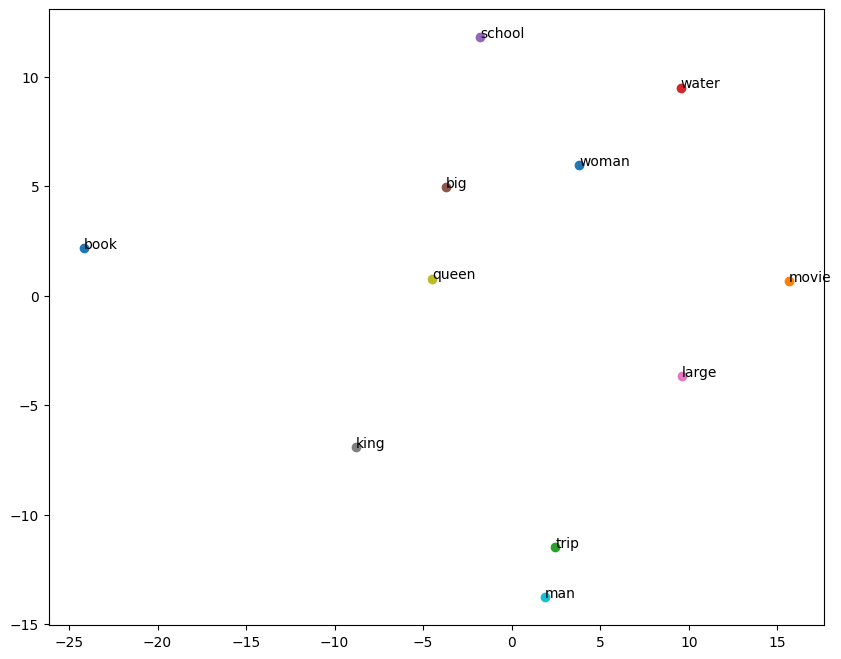

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_with_pca(embeddings, words, n_components=2):
    # Convert embeddings to numpy array if they're PyTorch tensors
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.numpy()
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10, 8))
    for i, word in enumerate(words):
        plt.scatter(reduced[i, 0], reduced[i, 1])
        plt.annotate(word, (reduced[i, 0], reduced[i, 1]))
    plt.show()

# Example usage:
embeddings = model.embeddings.weight.detach()  # Get your embeddings
words = ["book", "movie", "trip", "water", "school", "big", "large", "king", "queen", "man", "woman"]
word_indices = [word2idx[w] for w in words]
visualize_with_pca(embeddings[word_indices], words)